In [2]:
#用深层神经网络实现二分类图像识别

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import operator
from functools import reduce
import h5py

In [48]:
def load_2D_dataset():
    data = scipy.io.loadmat(r'C:\Users\alex\Desktop\data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=reduce(operator.add, train_Y), s=40, cmap=plt.cm.Spectral) 
    
    return train_X, train_Y, test_X, test_Y

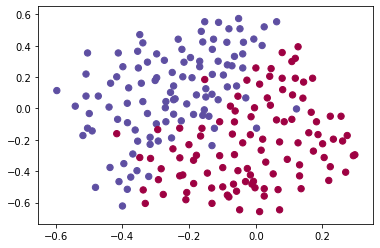

In [49]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [50]:
#使用L层神经网络，最后一层使用sigmoid函数，之前使用relu函数

In [71]:
#使用两层神经网络，使用relu函数和sigmoid函数，第一层n_h节点
def init_paramters_deep(Layer_dims):
    np.random.seed(3)
    paramters = {}
    for i in range(1,len(Layer_dims)):
        paramters['W'+str(i)] = np.random.randn(Layer_dims[i],Layer_dims[i-1])/np.sqrt(Layer_dims[i-1])#这也是个修改点
        paramters['b'+str(i)] = np.zeros((Layer_dims[i],1))
    return paramters

In [52]:
#定义激活函数
def activation(x,activate):
    if(activate=='relu'):
        return (abs(x)+x)/2
    if(activate=='sigmoid'):
        return 1/(1+np.exp(-x))

In [145]:
#进行前向传播
def forward(X,paramters,keep_prob):
    cache = {}
    a = X
    cache['A0']=X
    length = len(paramters)//2+1
    for i in range(1,length):
        W = paramters['W'+str(i)]
        b = paramters['b'+str(i)]
        Z = np.dot(W,a)+b
        cache['Z'+str(i)] = Z
        if(i!=length-1):
            a = activation(Z,'relu')
            D = np.random.rand(a.shape[0],a.shape[1])
            D = (D<keep_prob).astype(int) 
            cache['D'+str(i)] = D
            a = a*D
            a =a/keep_prob
        else:
            a = activation(Z,'sigmoid')
        cache['A'+str(i)] = a
    return cache

In [146]:
#计算损失函数
def computeCost(A,Y,lamdb,Layer_dims,parameters):
    m = Y.shape[1]
    reg = 0
    cost = (-1/A.shape[1])*np.nansum((Y*np.log(A))+(1-Y)*np.log(1-A))
    if(lamdb==0):
        return cost
    else:
        for i in range(1,len(Layer_dims)):
            reg +=np.sum(np.square(parameters['W'+str(i)]))
    return cost+(lamdb/(2*m))*reg

In [147]:
#进行反向传播计算
def backward(X,caches,Y,paramters,lamdb,keep_prob):
    m = X.shape[1]
    length = len(paramters)//2+1
    grads={}
    dZ = caches['A'+str(length-1)]-Y
    for i in reversed(range(1,length)):
        w = paramters['W'+str(i)]
        a_prev = caches['A'+str(i-1)]
        dw = (1./m)*np.dot(dZ,a_prev.T)+(lamdb/m)*w
        db = (1./m)*np.sum(dZ,axis=1,keepdims=True)
        if i-1!=0:
            d = caches['D'+str(i-1)]
            da_prev = np.dot(w.T,dZ)*d
            da_prev/=keep_prob
        else:
            da_prev = np.dot(w.T,dZ)
        dZ = np.multiply(da_prev, np.int64(a_prev > 0))#这一步，关键所在
        grads['dW'+str(i)] = dw
        grads['db'+str(i)] = db
    return grads

In [148]:
def update_paramters(paramters,grads,learning_rate):
    length = len(paramters)//2+1
    for i in range(1,length):
        paramters['W'+str(i)] = paramters['W'+str(i)]-learning_rate*grads['dW'+str(i)]
        paramters['b'+str(i)] = paramters['b'+str(i)]-learning_rate*grads['db'+str(i)]
    return paramters

In [182]:
def predicts(X,y,paramters):
    caches = forward(X,paramters,1)
    length = len(paramters)//2
    a = caches['A'+str(length)]
    y_prediction = np.zeros((1,y.shape[1]))
    for i in range(y.shape[1]):
        if(a[0,i]>=0.5):
            y_prediction[0,i] = 1
        else:
            y_prediction[0,i] = 0
    return y_prediction

In [154]:
#建立浅层神经网络模型
def nn_model(X,Y,learning_rate,iterations,layer_dims,lamdb,keep_prob):
    losses = []
    paramters = init_paramters_deep(layer_dims)#完全一致
    length = len(layer_dims)
    for i in range(iterations):
        caches = forward(X,paramters,keep_prob)
        cost = computeCost(caches['A'+str(length-1)],Y,lamdb,layer_dims,parameters)
        grads = backward(X,caches,Y,paramters,lamdb,keep_prob)
        paramters  = update_paramters(paramters,grads,learning_rate)
        losses.append(cost)
        if(i%100==0):
            print(cost)
    plt.plot(losses)
    return paramters,losses

In [155]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    caches = forward(X, parameters,1)
    a3 = caches['A3']
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [156]:
layer_dims = [train_X.shape[0],20,3,1]

0.6572955604376453
0.3403234735386809
0.3168478840493342
0.3116263947213816
0.321719788711318
0.31940760503795584
0.2741333313184053
0.2700018969473325
0.3201770662825074
0.2730321096682714
0.2570354489898663
0.27115541046753533
0.23897416783737271
0.23509523360634643
0.23040285606672675
0.2772330662229546
0.24172370133518642
0.2552033417366868
0.2630148732306175
0.2314926653408645
0.23699767268020797
0.21834499121689285
0.224301740741632
0.23134176042461746
0.24158506594002357
0.21696852169931094
0.19809407476383814
0.23993104581685273
0.22520978570290634
0.2010230912613196
0.22010948771691122
0.19294843872452602
0.22753018961404944
0.2409350737965734
0.21944820288077213
0.21690061090127719
0.20043737573578954
0.21405233207104815
0.24095339298598184
0.22203850753283383
0.18945489645037503
0.2262378847797858
0.19542683448647946
0.20998549212744747
0.22111425419913316
0.2169634180990802
0.22003619865046067
0.18910982600704224
0.21486928019601137
0.2201680439257886
0.20418726861729752
0.

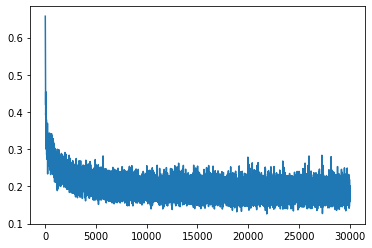

In [164]:
parameters,loss = nn_model(train_X, train_Y,0.3,30000,layer_dims,0,0.85)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

In [165]:
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    cache = forward(X, parameters,1)
    a3 = cache['A3']
    predictions = (a3>0.5)
    return predictions

In [166]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :],  c=reduce(operator.add, y), cmap=plt.cm.Spectral)
    plt.show()

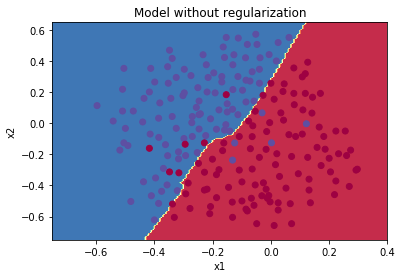

In [167]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
#以下使用二分类图像进行测试

In [170]:
f = h5py.File(r"C:\Users\alex\Desktop\train_catvnoncat.h5",'r')

In [171]:
train_set_ori_x = np.array(f['train_set_x'][:])
train_set_ori_y = np.array(f['train_set_y'][:])

In [172]:
f = h5py.File(r"C:\Users\alex\Desktop\test_catvnoncat.h5",'r')

In [173]:
test_set_ori_x = np.array(f['test_set_x'][:])
test_set_ori_y = np.array(f['test_set_y'][:])

In [174]:
train_set_x = train_set_ori_x.reshape(train_set_ori_x.shape[0],-1).T
train_set_y = train_set_ori_y.reshape(1,-1)
test_set_x=test_set_ori_x.reshape(test_set_ori_x.shape[0],-1).T
test_set_y = test_set_ori_y.reshape(1,-1)

In [175]:
train_set_x = train_set_x/255
m = train_set_y.shape[1]
test_set_x = test_set_x/255

In [177]:
layer_dims = [train_set_x.shape[0],4,2,1]

0.6897113624396723
0.5758549138198769
0.51642272842684
0.4797059761520589
0.4427414611073798
0.43901809873993236
0.4063194716719829
0.3583944264513775
0.34129265446107726
0.32383690524999564
0.3305711712835718
0.3129384314072579
0.28473752691287224
0.2504807040175057
0.26917033810066715
0.2290121945833793
0.21420232494454972
0.20647573719277176
0.20959151437701695
0.18384528876736894
0.1745637266029021
0.17580165599086187
0.1628254923722399
0.1571123661257536
0.15781164593473457
0.14596243398691186
0.1393092932673193
0.13289429530082827
0.12899614522091904
0.12487867377798728


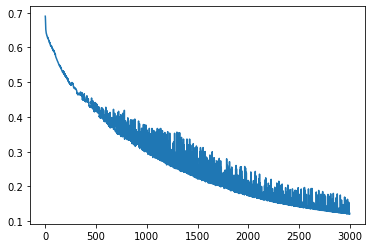

In [179]:
paramters,losses=nn_model(train_set_x,train_set_y,0.005,3000,layer_dims,0,1)

In [52]:
print(paramters)

{'W1': array([[ 0.00203212,  0.00973785,  0.00759412, ...,  0.00155505,
         0.01589943, -0.00073817],
       [-0.00681171,  0.02219576,  0.00886221, ...,  0.0104867 ,
         0.01981471, -0.01667363],
       [ 0.00741829, -0.01136251, -0.0063522 , ...,  0.00203142,
        -0.01290087,  0.01541243],
       [ 0.00966089, -0.01002128, -0.00075109, ...,  0.00249649,
        -0.00731451,  0.01451967]]), 'b1': array([[-2.89450825e-03],
       [-2.28999450e-05],
       [-9.52563045e-03],
       [-8.43253069e-03]]), 'W2': array([[-0.51573297, -1.08030554,  0.84413368,  0.62502777]]), 'b2': array([[-0.0929672]])}


In [183]:
y_prediction_train = predicts(train_set_x,train_set_y,paramters)
y_prediction_test = predicts(test_set_x,test_set_y,paramters)
print('train accuracy: {} %'.format(100-np.mean(np.abs(y_prediction_train-train_set_y))*100))
print('test accuracy: {} %'.format(100-np.mean(np.abs(y_prediction_test-test_set_y))*100))

train accuracy: 99.04306220095694 %
test accuracy: 58.0 %


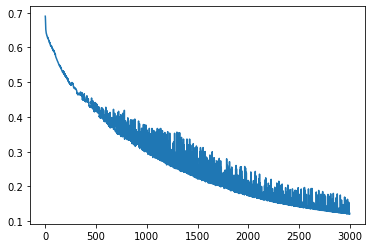

In [184]:
plt.plot(losses)

1.6629209418069224
1.5535026898671886
1.4910489680068815
1.4607045228277533
1.4173823561921615
1.3913892037858924
1.3864880153442145
1.3488823168828312
1.310349012991695
1.3009222160861882
1.3130806005614821
1.3394832119813722
1.2475192249627793
1.240450725692853
1.2410480246759104
1.244751065342587
1.201907008620313
1.2440529676043246
1.1729666328236161
1.16063950708147
1.1515124173231004
1.2000702798795888
1.15593076487946
1.131244179395281
1.1230813209014803
1.1183159589350662
1.113161137927039
1.1090172674299423
1.105421214516836
1.1025272007088618


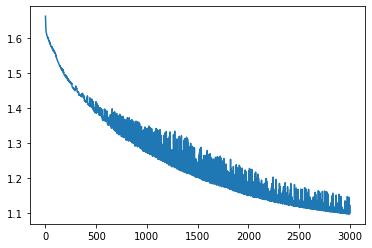

In [185]:
#可以判断出，过拟合严重,于是进行L2正则化
paramters,losses=nn_model(train_set_x,train_set_y,0.005,3000,layer_dims,0.7,1)

In [186]:
#正则化后，准确率提升
y_prediction_train = predicts(train_set_x,train_set_y,paramters)
y_prediction_test = predicts(test_set_x,test_set_y,paramters)
print('train accuracy: {} %'.format(100-np.mean(np.abs(y_prediction_train-train_set_y))*100))
print('test accuracy: {} %'.format(100-np.mean(np.abs(y_prediction_test-test_set_y))*100))

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


0.6903855807219296
0.586535564643512
0.5378937548943598
0.5236233149793724
0.4997039286003419
0.46003580631315455
0.45072887620036045
0.43620870355323527
0.40410862461063823
0.3983367391763124
0.4181885229294
0.3758919002896335
0.36814552622028646
0.3352425872782558
0.33167800888723264
0.32303620621221785
0.31283940583377573
0.29262836664897585
0.2962170918901078
0.3241242646286864
0.26593986089076277
0.26608558565870927
0.2864529380412349
0.26385134528066867
0.2540906784850937
0.2683333769113302
0.259087807268506
0.2560609405292262
0.2457720804631934
0.23805163871164509


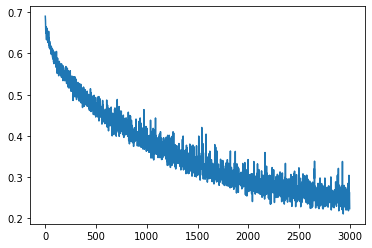

In [187]:
#使用dropout，不用L2正则化测试
paramters,losses=nn_model(train_set_x,train_set_y,0.005,3000,layer_dims,0,0.85)

In [188]:
#相比未正则化，效果也有所增加
y_prediction_train = predicts(train_set_x,train_set_y,paramters)
y_prediction_test = predicts(test_set_x,test_set_y,paramters)
print('train accuracy: {} %'.format(100-np.mean(np.abs(y_prediction_train-train_set_y))*100))
print('test accuracy: {} %'.format(100-np.mean(np.abs(y_prediction_test-test_set_y))*100))

train accuracy: 97.60765550239235 %
test accuracy: 62.0 %
